In [1]:
!pip install -q tsaug

## Import

In [2]:
!nvidia-smi

Thu Dec  1 03:31:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Hyperparameter Setting

In [6]:
CFG = {
    'X_RANGE': 7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-2,
    'BATCH_SIZE': 128,
    'SEED': 41
}

## Fixed RandomSeed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [8]:
path = '/content/drive/MyDrive/Colab Notebooks/dacon/ddareung/'

train = pd.read_csv(path+'data/train.csv')

In [9]:
train.head()

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308


In [10]:
train['일시'].min(), train['일시'].max()

(20180101, 20211231)

In [11]:
train.iloc[:, 1:].corr()

,광진구,동대문구,성동구,중랑구
광진구,1.000000,0.931677,0.982757,0.940734
동대문구,0.931677,1.000000,0.944432,0.986240
성동구,0.982757,0.944432,1.000000,0.957428
중랑구,0.940734,0.986240,0.957428,1.000000


## Data Visualization

In [12]:
def get_view_df(df, target):
    viewd = df[['일시', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    print(target)
    sns.set(rc={'figure.figsize':(30, 8)})
    sns.lineplot(x='index', y=target, data=viewd)
    plt.show()

광진구


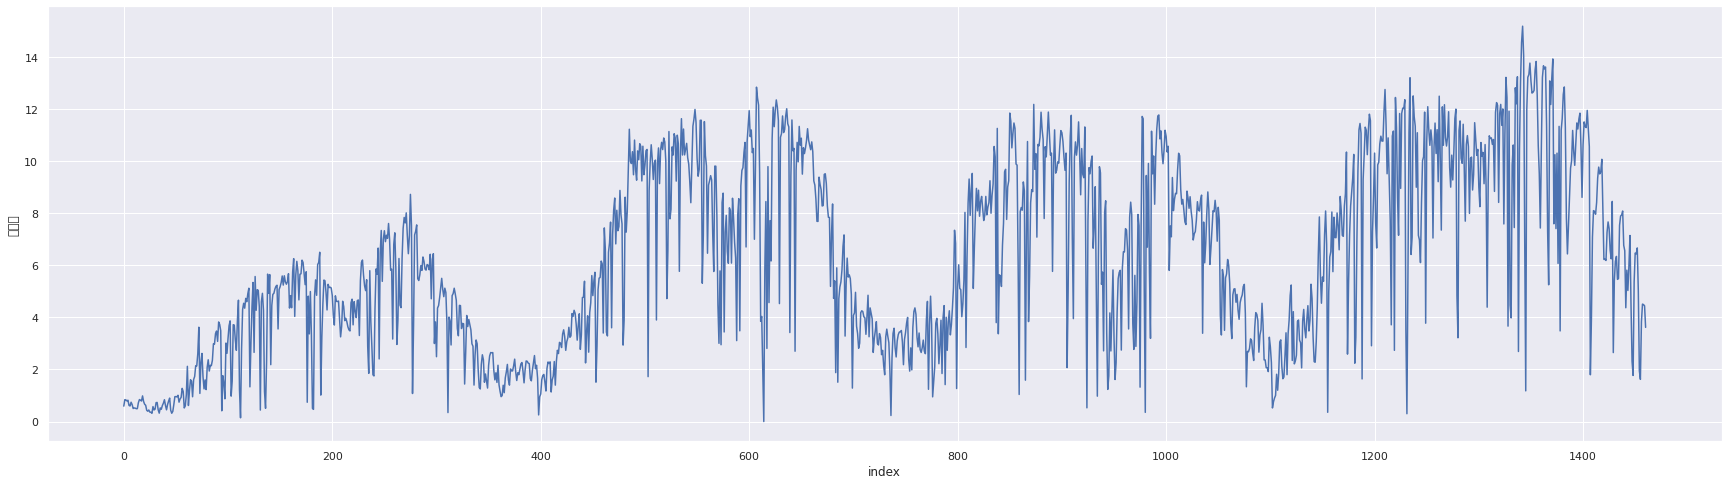

동대문구


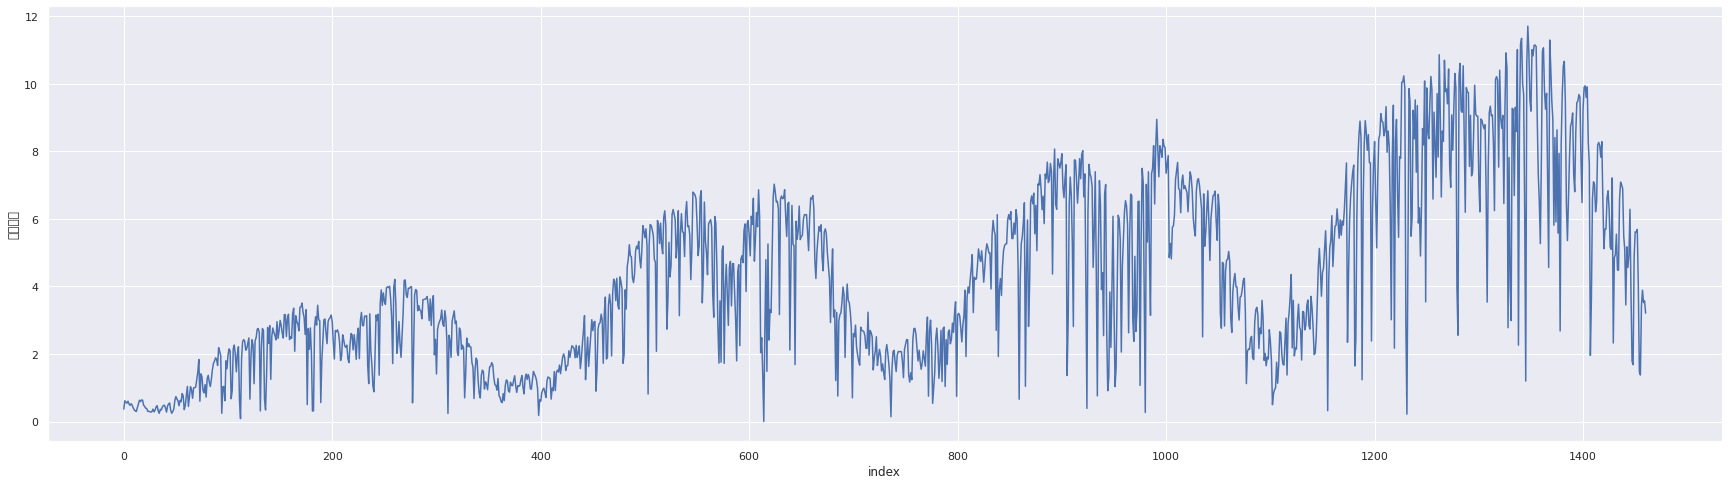

성동구


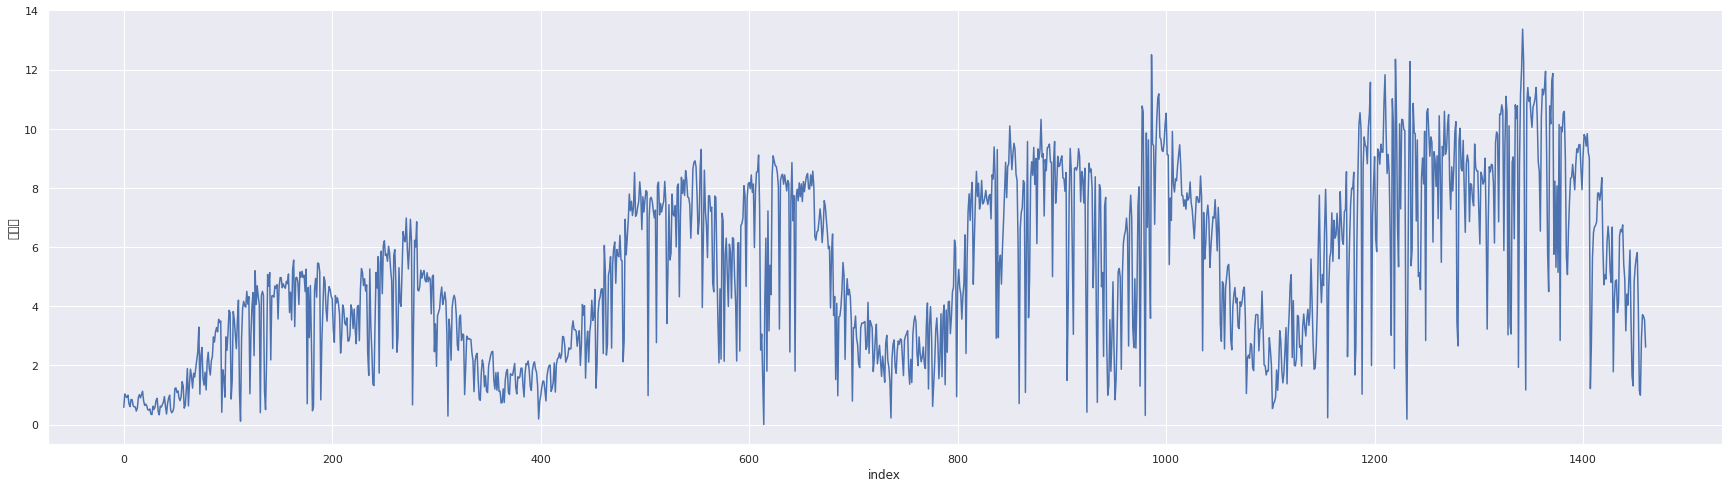

중랑구


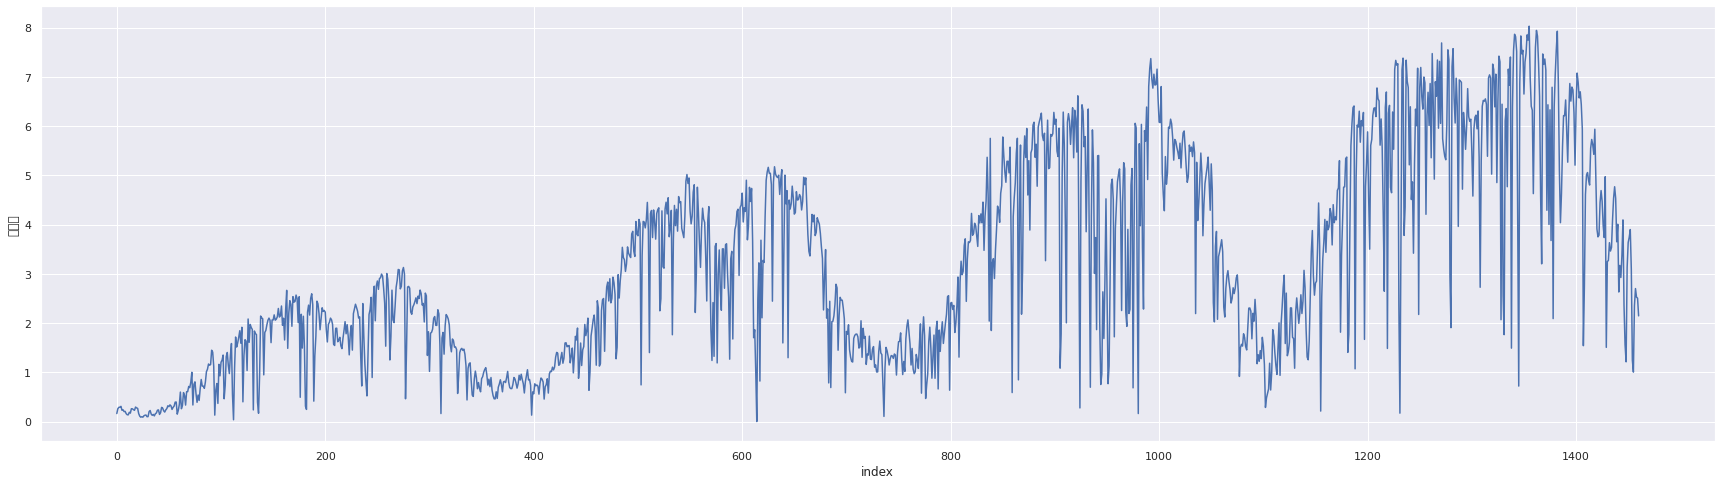

In [13]:
get_view_df(train, '광진구')
get_view_df(train, '동대문구')
get_view_df(train, '성동구')
get_view_df(train, '중랑구')

## Augmentation

In [14]:
import tsaug
from tsaug import AddNoise, Convolve, Crop, Drift, Pool, Quantize, Resize, Reverse, TimeWarp
from tsaug.visualization import plot

In [15]:
X = np.arange(len(train))
Y1 = np.array(train['광진구'].tolist())
Y2 = np.array(train['동대문구'].tolist())
Y3 = np.array(train['성동구'].tolist())
Y4 = np.array(train['중랑구'].tolist())

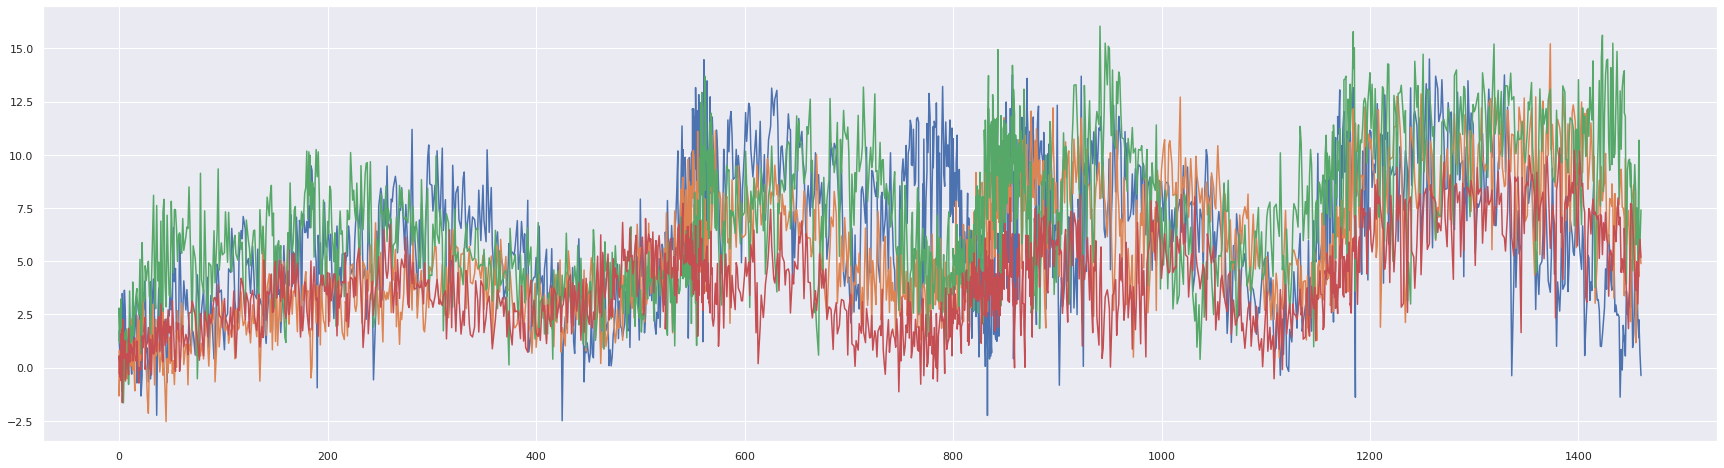

In [16]:
my_augmenter = (
                TimeWarp(n_speed_change=20, max_speed_ratio=5) # random time warping
                #+ Crop(size=100)  # random crop subsequences with length 300
                + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
                + Drift(max_drift=(0.1, 0.3))  # with 80% probability, random drift the signal up to 10% - 50%
                #+ Reverse() @ 0.5  # with 50% probability, reverse the sequence
                + AddNoise()
                )
# Build a pipeline of augmenters 
Y_aug1, X_aug = my_augmenter.augment(Y1, X)
Y_aug2, X_aug = my_augmenter.augment(Y2, X)
Y_aug3, X_aug = my_augmenter.augment(Y3, X)
Y_aug4, X_aug = my_augmenter.augment(Y4, X)

plt.plot(X_aug, Y_aug1)
plt.plot(X_aug, Y_aug2)
plt.plot(X_aug, Y_aug3)
plt.plot(X_aug, Y_aug4)

In [17]:
train['광진구_aug'] = Y_aug1
train['동대문구_aug'] = Y_aug2
train['성동구_aug'] = Y_aug3
train['중랑구_aug'] = Y_aug4

In [18]:
train

,일시,광진구,동대문구,성동구,중랑구,광진구_aug,동대문구_aug,성동구_aug,중랑구_aug
0,20180101,0.592,0.368,0.580,0.162,1.728563,0.806408,1.261717,-0.291588
1,20180102,0.840,0.614,1.034,0.260,1.255066,-1.335924,2.796046,0.549893
2,20180103,0.828,0.576,0.952,0.288,0.407590,0.764565,1.144484,0.013548
3,20180104,0.792,0.542,0.914,0.292,0.954157,-0.211069,2.006774,-0.448465
4,20180105,0.818,0.602,0.994,0.308,0.040195,-0.351794,3.235132,1.594783
...,...,...,...,...,...,...,...,...,...
1456,20211227,3.830,3.416,2.908,2.350,2.227659,4.949657,5.021054,2.990877
1457,20211228,4.510,3.890,3.714,2.700,1.405553,4.281577,10.687794,5.064388
1458,20211229,4.490,3.524,3.660,2.524,2.247456,6.376118,6.510749,5.242292
1459,20211230,4.444,3.574,3.530,2.506,0.689833,5.502652,5.768014,6.031260


## Seasonal Decompose

In [19]:
from datetime import datetime

train['일시'] = train.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
train.set_index('일시', inplace=True)

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def func_diff(location, lamb):
    # 계절성 제거
    result = seasonal_decompose(train['{}'.format(location)], model='additive')
    result = result.observed
    
    # 추세 변동요인 추출 - trend
    cycle, trend = sm.tsa.filters.hpfilter(result, lamb)
    data_불규칙 = pd.DataFrame(cycle)

    # 불규칙 변동요인 제거한 순환변동요인 추출 - cycle2
    unrule, cycle2 = sm.tsa.filters.hpfilter(data_불규칙, lamb)

    # 표준화
    cycle_std = (cycle2-np.mean(cycle2))/np.std(cycle2)

    train['cycle_{}'.format(location)] = cycle_std
    train['unrule_{}'.format(location)] = unrule
    train['trend_{}'.format(location)] = trend

In [21]:
func_diff('광진구', 14400) #129600
func_diff('동대문구', 14400)
func_diff('성동구', 14400)
func_diff('중랑구', 14400)

In [22]:
train = train.reset_index()
train['일시'] = train['일시'].astype(str)

In [23]:
train.head()

,일시,광진구,동대문구,성동구,중랑구,광진구_aug,동대문구_aug,성동구_aug,중랑구_aug,cycle_광진구,...,trend_광진구,cycle_동대문구,unrule_동대문구,trend_동대문구,cycle_성동구,unrule_성동구,trend_성동구,cycle_중랑구,unrule_중랑구,trend_중랑구
0,2018-01-01,0.592,0.368,0.580,0.162,1.728563,0.806408,1.261717,-0.291588,0.429076,...,0.706571,0.446535,-0.176746,0.512872,0.497048,-0.289025,0.815124,0.379444,-0.093799,0.234426
1,2018-01-02,0.840,0.614,1.034,0.260,1.255066,-1.335924,2.796046,0.549893,0.411879,...,0.698336,0.429486,0.076363,0.506980,0.476936,0.176143,0.806137,0.361588,0.008709,0.230924
2,2018-01-03,0.828,0.576,0.952,0.288,0.407590,0.764565,1.144484,0.013548,0.394589,...,0.690093,0.412265,0.045494,0.501077,0.456640,0.105348,0.797134,0.343616,0.041229,0.227416
3,2018-01-04,0.792,0.542,0.914,0.292,0.954157,-0.211069,2.006774,-0.448465,0.377161,...,0.681844,0.394774,0.018658,0.495163,0.436087,0.078597,0.788113,0.325423,0.049769,0.223901
4,2018-01-05,0.818,0.602,0.994,0.308,0.040195,-0.351794,3.235132,1.594783,0.359602,...,0.673600,0.376960,0.085854,0.489238,0.415271,0.169881,0.779086,0.306956,0.070331,0.220379


## Train / Validation Split

In [24]:
val_df = train.iloc[1096-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train.iloc[:1096].reset_index().drop(columns='index') # 20180101 ~ 20201231

In [25]:
train_df.shape, val_df.shape

((1096, 21), (372, 21))

## Data Pre-processing

In [26]:
# 광진구, 동대문구, 성동구, 중랑구

def get_x_y_data_feature(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구', '광진구_aug',
                                          'cycle_동대문구', 'unrule_동대문구', 'trend_동대문구', '동대문구_aug',
                                          'cycle_성동구', 'unrule_성동구', 'trend_성동구', '성동구_aug',
                                          'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구', '중랑구_aug']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [27]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[5:7].astype(int)/12.
    df['일'] = df['일시'].str[8:10].astype(int)/31.
    
    df = df.drop('일시', axis=1)
    return df

In [28]:
train_df = make_ymd_feature(train_df)
val_df = make_ymd_feature(val_df)

In [29]:
train_x_1, train_y_1 = get_x_y_data_feature(train_df)
val_x_1, val_y_1 = get_x_y_data_feature(val_df)

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

In [30]:
train_x_1[0].shape

(7, 23)

## CustomDataset

In [31]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [32]:
train_dataset_1 = CustomDataset(train_x_1, train_y_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0, drop_last=True)

val_dataset_1 = CustomDataset(val_x_1, val_y_1)
val_loader_1 = DataLoader(val_dataset_1, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0, drop_last=True)

In [33]:
train_dataset_1[0][0].shape, train_dataset_1[0][1].shape

(torch.Size([7, 23]), torch.Size([16]))

## Define Model

In [34]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=23, hidden_size=256, num_layers=1, batch_first=True)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:, -1,:])
        return output

## Train

In [35]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model
    return best_model

In [36]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [37]:
model = BaseModel()

In [38]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader_1, val_loader_1, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [2.41034] Val MAE : [2.96121]
Epoch : [2] Train Loss : [1.64260] Val MAE : [1.65304]
Epoch : [3] Train Loss : [1.08609] Val MAE : [3.11626]
Epoch : [4] Train Loss : [0.90244] Val MAE : [1.55149]
Epoch : [5] Train Loss : [0.81223] Val MAE : [1.40367]
Epoch : [6] Train Loss : [0.77723] Val MAE : [1.24755]
Epoch : [7] Train Loss : [0.75679] Val MAE : [1.10170]
Epoch : [8] Train Loss : [0.74946] Val MAE : [1.17441]
Epoch 00008: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [9] Train Loss : [0.72854] Val MAE : [1.07970]
Epoch : [10] Train Loss : [0.72756] Val MAE : [1.06612]
Epoch : [11] Train Loss : [0.71360] Val MAE : [1.06299]
Epoch : [12] Train Loss : [0.71438] Val MAE : [1.17650]
Epoch : [13] Train Loss : [0.71132] Val MAE : [1.07949]
Epoch 00013: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [14] Train Loss : [0.70912] Val MAE : [1.05064]
Epoch : [15] Train Loss : [0.68633] Val MAE : [1.06146]
Epoch : [16] Train Loss : [0.68191] Val MAE :

## Inference

In [39]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [40]:
test_df = pd.read_csv(path+'data/sample_submission.csv')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')

In [41]:
test_df.head()

,광진구,동대문구,성동구,중랑구,광진구_aug,동대문구_aug,성동구_aug,중랑구_aug,cycle_광진구,unrule_광진구,...,trend_동대문구,cycle_성동구,unrule_성동구,trend_성동구,cycle_중랑구,unrule_중랑구,trend_중랑구,년,월,일
0,1.946,1.474,1.148,1.246,4.604734,1.168323,5.779826,4.211626,-0.081750,-2.383935,...,3.693279,0.030141,-2.313147,3.457879,0.002368,-1.284133,2.530000,2.021,1.0,0.806452
1,1.620,1.378,0.992,1.004,4.382952,2.949640,7.507216,4.984306,-0.093048,-2.604659,...,3.602715,0.017662,-2.383297,3.373382,0.020844,-1.466341,2.469167,2.021,1.0,0.838710
2,3.830,3.416,2.908,2.350,2.227659,4.949657,5.021054,2.990877,-0.101798,-0.289997,...,3.512362,0.006846,-0.381806,3.289063,0.042131,-0.060873,2.408499,2.021,1.0,0.870968
3,4.510,3.890,3.714,2.700,1.405553,4.281577,10.687794,5.064388,-0.108748,0.494229,...,3.422153,-0.002842,0.509443,3.204865,0.065288,0.348381,2.347941,2.021,1.0,0.903226
4,4.490,3.524,3.660,2.524,2.247456,6.376118,6.510749,5.242292,-0.114807,0.578241,...,3.332016,-0.012180,0.540617,3.120704,0.089298,0.231536,2.287434,2.021,1.0,0.935484


In [42]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구', '광진구_aug',
                   'cycle_동대문구', 'unrule_동대문구', 'trend_동대문구', '동대문구_aug',
                   'cycle_성동구', 'unrule_성동구', 'trend_성동구', '성동구_aug',
                   'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구', '중랑구_aug']] = model_pred
                                    
    return df.loc[CFG['X_RANGE']:, ['cycle_광진구', 'unrule_광진구', 'trend_광진구', '광진구_aug',
                                    'cycle_동대문구', 'unrule_동대문구', 'trend_동대문구', '동대문구_aug',
                                    'cycle_성동구', 'unrule_성동구', 'trend_성동구', '성동구_aug',
                                    'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구', '중랑구_aug']].reset_index().drop(columns=['index'])

In [43]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [44]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Main Model

In [45]:
CFG = {
    'X_RANGE': 7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-2,
    'BATCH_SIZE': 128,
    'SEED': 42
}

In [46]:
train_df.columns

Index(['광진구', '동대문구', '성동구', '중랑구', '광진구_aug', '동대문구_aug', '성동구_aug',
       '중랑구_aug', 'cycle_광진구', 'unrule_광진구', 'trend_광진구', 'cycle_동대문구',
       'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구', 'trend_성동구',
       'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구', '년', '월', '일'],
      dtype='object')

In [47]:
def get_x_y_data(df, infer=False, column='광진구'):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, [f'{column}', f'{column}_aug', 
                                                             f'cycle_{column}', f'unrule_{column}']]).astype(float))
        y_data.append(np.array(df.loc[i, [f'{column}']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [98]:
train_x, train_y = get_x_y_data(df=train_df, infer=False, column='중랑구')
val_x, val_y = get_x_y_data(df=val_df, infer=False, column='중랑구')

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

In [99]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0, drop_last=True)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0, drop_last=True)

In [100]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([7, 4]), torch.Size([1]))

In [101]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=256, num_layers=1, batch_first=True)
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:, -1,:])
        return output

In [102]:
model = Model()

In [103]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [2.09854] Val MAE : [2.38236]
Epoch : [2] Train Loss : [0.91407] Val MAE : [4.21347]
Epoch : [3] Train Loss : [0.67520] Val MAE : [9.02625]
Epoch : [4] Train Loss : [0.58225] Val MAE : [4.17355]
Epoch : [5] Train Loss : [0.52339] Val MAE : [1.29716]
Epoch : [6] Train Loss : [0.52045] Val MAE : [1.03989]
Epoch : [7] Train Loss : [0.52314] Val MAE : [1.52667]
Epoch : [8] Train Loss : [0.49743] Val MAE : [1.45342]
Epoch 00008: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [9] Train Loss : [0.48158] Val MAE : [1.28761]
Epoch : [10] Train Loss : [0.50709] Val MAE : [1.00253]
Epoch : [11] Train Loss : [0.47916] Val MAE : [0.98925]
Epoch : [12] Train Loss : [0.46659] Val MAE : [0.90281]
Epoch : [13] Train Loss : [0.44996] Val MAE : [0.94418]
Epoch 00013: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [14] Train Loss : [0.45234] Val MAE : [0.98992]
Epoch : [15] Train Loss : [0.42861] Val MAE : [0.88677]
Epoch : [16] Train Loss : [0.44717] Val MAE :

In [104]:
def inference(model, df, device, column='광진구'):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, [f'{column}', f'{column}_aug',
                                                                f'cycle_{column}', f'unrule_{column}']]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, [f'{column}']] = model_pred
    return df.loc[CFG['X_RANGE']:, [f'{column}']].reset_index().drop(columns=['index'])

In [105]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

preds = inference(best_model, test_df, device, column='중랑구')

  0%|          | 0/334 [00:00<?, ?it/s]

In [106]:
preds

,중랑구
0,2.298680
1,2.313881
2,2.166217
3,2.026645
4,1.913494
...,...
329,2.395821
330,2.395723
331,2.395618
332,2.395505


In [78]:
preds_gwangjin = preds

In [88]:
preds_dongdae = preds

In [97]:
preds_seongdong = preds

In [107]:
preds_jungrang = preds

## Submission

In [109]:
submit = pd.read_csv(path+'data/sample_submission.csv')
submit.head()

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0


In [110]:
submit['광진구'] = preds_gwangjin.round(3)
submit['동대문구'] = preds_dongdae.round(3)
submit['성동구'] = preds_seongdong.round(3)
submit['중랑구'] = preds_jungrang.round(3)

In [111]:
submit

,일시,광진구,동대문구,성동구,중랑구
0,20220101,4.085,3.020,2.889,2.299
1,20220102,4.408,3.077,3.071,2.314
2,20220103,4.307,2.977,2.939,2.166
3,20220104,4.156,2.883,2.725,2.027
4,20220105,4.118,2.839,2.754,1.913
...,...,...,...,...,...
329,20221126,5.206,3.956,4.777,2.396
330,20221127,5.206,3.956,4.777,2.396
331,20221128,5.207,3.956,4.777,2.396
332,20221129,5.207,3.956,4.777,2.396


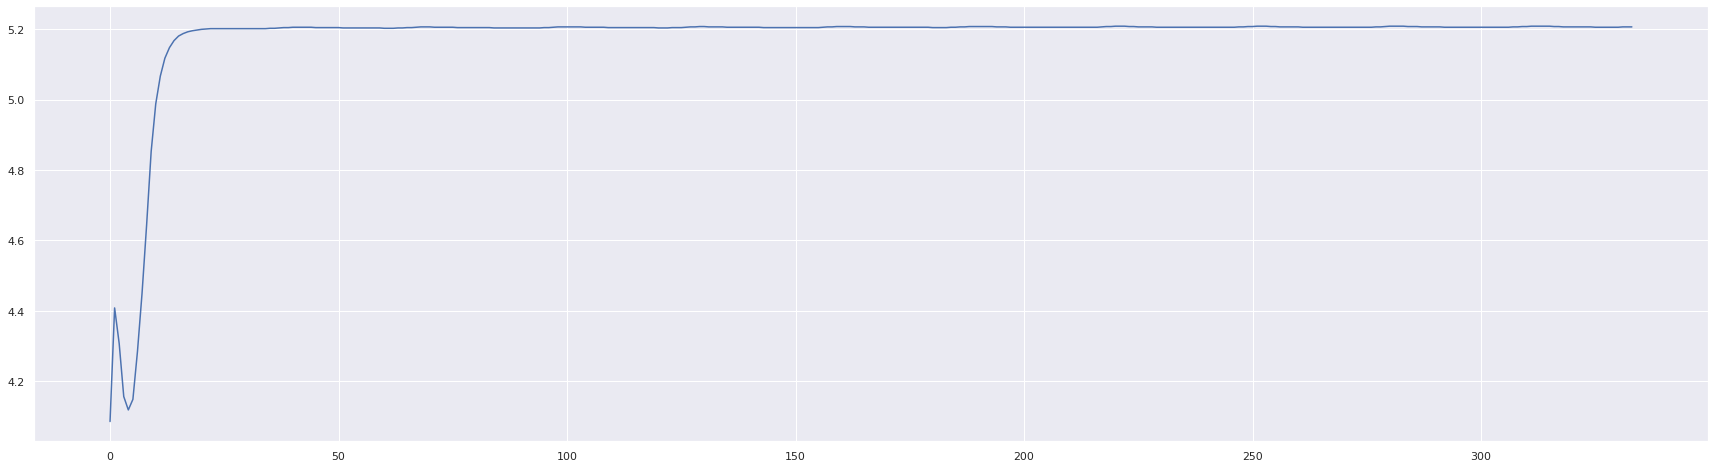

In [112]:
submit['광진구'].plot()

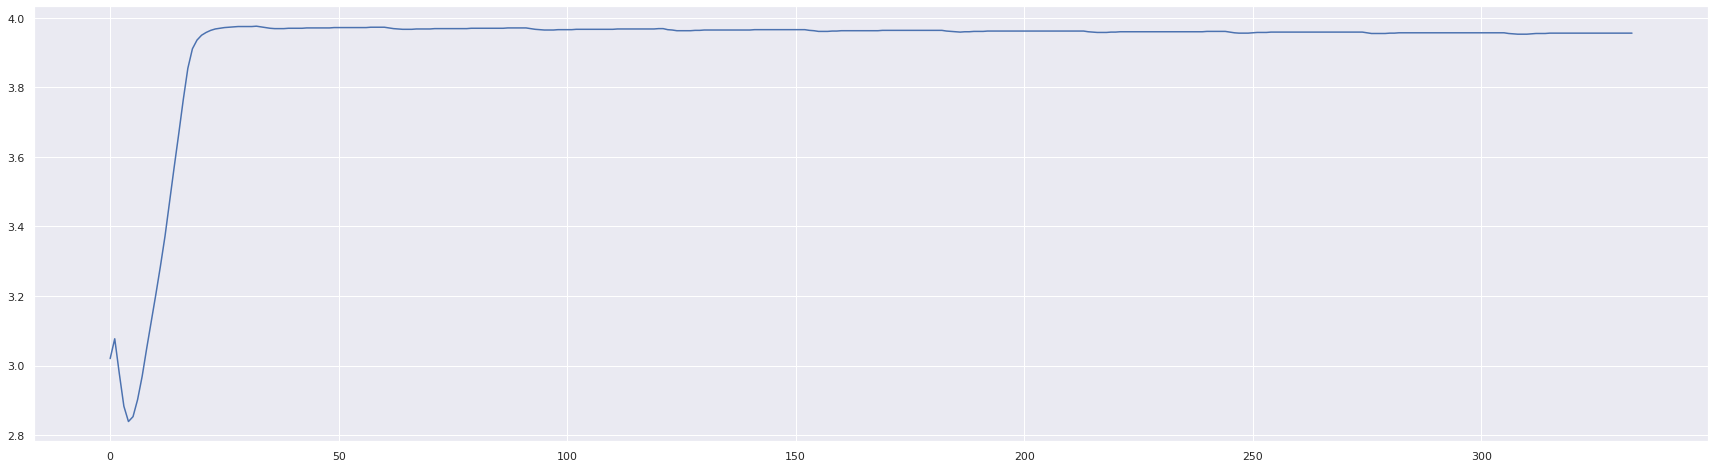

In [113]:
submit['동대문구'].plot()

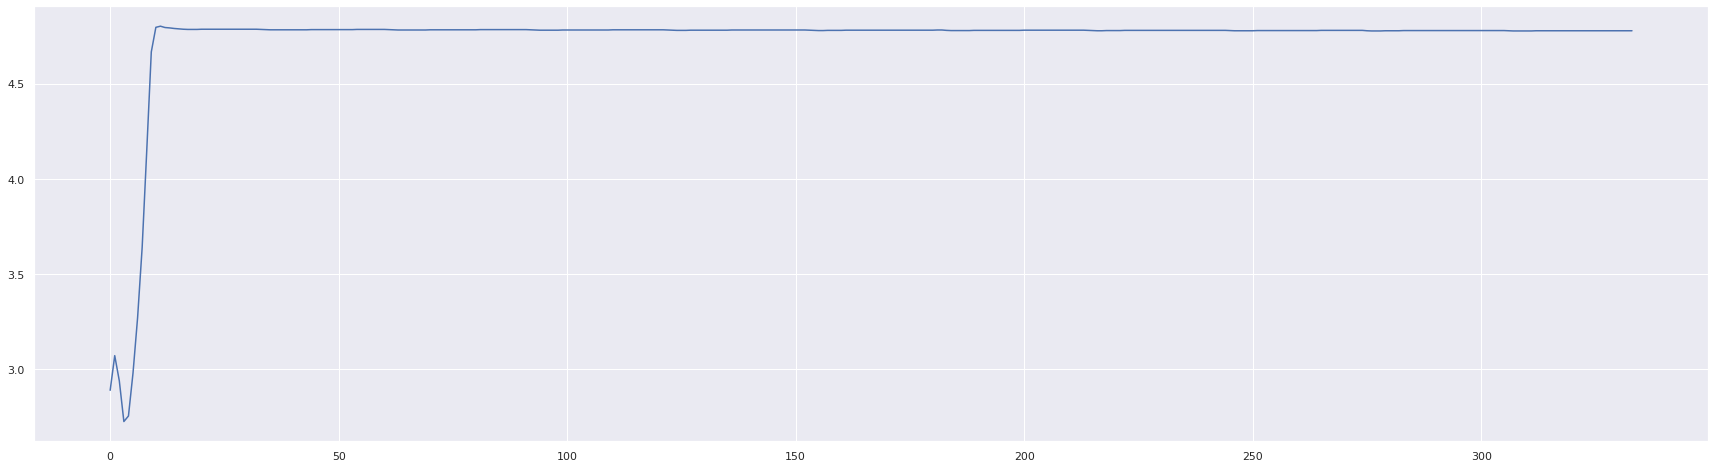

In [114]:
submit['성동구'].plot()

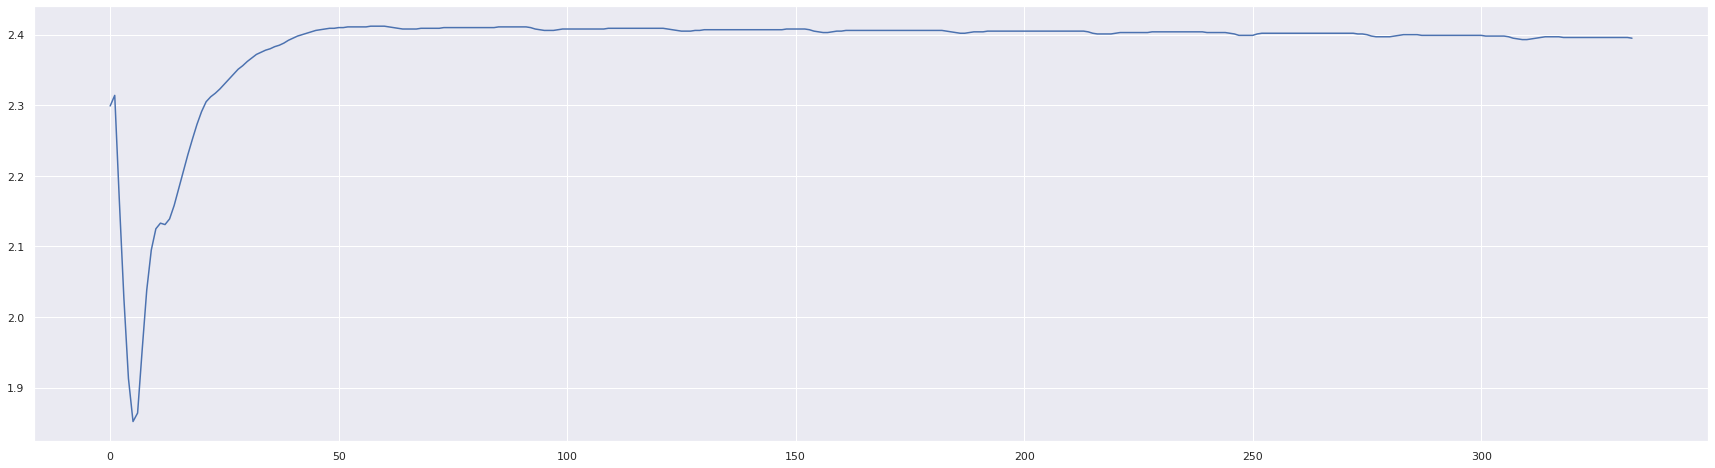

In [115]:
submit['중랑구'].plot()

In [ ]:
submit.to_csv('submission/submit_1129.csv', index=False)